In [74]:
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib
print("Matplotlib version for info:", matplotlib.__version__)

Matplotlib version for info: 3.9.4


In [75]:
concept_dict = torch.load('/netscratch/kadir/xl-vlms/results/decompose_activations_text_grounding_image_grounding_qwen2_results_patch_pca.pth')
#print(results_dict['grounding_words_overlap_matrix'])

concepts = concept_dict['concepts']
activations = concept_dict['activations']
text_grounding = concept_dict['text_grounding']
image_paths = concept_dict['image_grounding_paths']
print (f"Concepts shape: {concepts.shape}", f"Activations shape: {activations.shape}")


Concepts shape: torch.Size([15, 3584]) Activations shape: torch.Size([17, 15])


In [76]:
feat_path = '/netscratch/kadir/xl-vlms/features/save_hidden_states_for_token_of_interest_qwen2_chair_image_generation_split_train.pth'
test_features = torch.load(feat_path, map_location="cpu")
test_features.keys()

dict_keys(['image', 'model_predictions', 'token_of_interest_mask', 'hidden_states'])

In [77]:
test_images = test_features["image"]
test_prediction = test_features['model_predictions']
token_interest_mask = test_features['token_of_interest_mask']
absolute_features = test_features['hidden_states']


In [78]:
token_interest_mask

[tensor([False])]

In [79]:
from analysis.feature_decomposition import (decompose_and_ground_activations,
                                            get_feature_matrix)
module_name = "model.norm"
token_idx = None
feat_matrix = get_feature_matrix(
            absolute_features,
            module_name=module_name,
            token_idx=token_idx,
        )

In [80]:
import analysis.feature_decomposition as analysis_decomposition
analysis_model = concept_dict["analysis_model"]
grounding_words = concept_dict["text_grounding"]
projections = analysis_decomposition.project_test_sample(
        sample=feat_matrix,
        analysis_model=analysis_model,
        decomposition_type=concept_dict["decomposition_method"],
    )

In [81]:
import numpy as np

def find_top_n_powerful_projection(data, n):
    """
    Finds the indices of the top n values for each row without changing the row order.

    Parameters:
    - data: List of lists or 2D numpy array.
    - n: Number of top values to find.

    Returns:
    - A list of lists where each sublist contains the indices of the top n values for the corresponding row.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Get the top n indices for each row
    top_n_indices = [np.argsort(row)[-n:][::-1] for row in data]
    
    return top_n_indices

In [82]:
n = 10 #mumber of concept to discover 
top_powerful_indexes = find_top_n_powerful_projection(projections, n)

In [119]:
#print(projections)
#print(top_powerful_indexes)

In [83]:
def remap_prjection_image_text(top_powerful_indexes, test_image_path, image_concept_path, text_concept_path):
    if len(top_powerful_indexes) != len(test_image_path):
        raise ValueError("The projection list and image list of test data not have equal number.")
    final_result = {}
    for each_image_path, concept_indexs in zip( test_image_path, top_powerful_indexes):
        final_result[each_image_path[0]] = {'vis_concepts':[image_concept_path[i] for i in concept_indexs], 'text_concept': [text_concept_path[i] for i in concept_indexs]}

    return final_result

In [84]:
test_data_remapped = remap_prjection_image_text(top_powerful_indexes, test_images, image_paths, text_grounding)

In [85]:
print(test_data_remapped)

{'/ds/images/coco_2014/train2014/COCO_train2014_000000057870.jpg': {'vis_concepts': [['/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_62.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_88.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_92.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_96.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_98.jpg'], ['/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_67.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_88.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_97.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_77.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_1.jpg'], ['/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_87.jpg', '/ds/images/xai_vision/train_pa

In [86]:
a_test_image = '/ds/images/coco_2014/train2014/COCO_train2014_000000057870.jpg'
print(test_data_remapped[a_test_image]['vis_concepts'][0])
print(test_data_remapped[a_test_image]['text_concept'][0])

['/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_62.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_88.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_92.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_96.jpg', '/ds/images/xai_vision/train_patches/COCO_train2014_000000057870_patch_98.jpg']
['vester', 'keyboard', 'rowing', 'erg', 'tennis', 'straight', 'dining', 'keyboard']


In [87]:
# all image type reader 

import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut
def load_image(file_path):
    """
    Load an image file (.dcm, .jpeg, .png).

    Parameters:
        file_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image as a PIL object.
    """
    # Extract the file extension
    ext = os.path.splitext(file_path)[-1].lower()

    if ext == ".dcm":
        # Load DICOM file
        dicom_data = pydicom.dcmread(file_path)
        image = dicom_data.pixel_array
        
        return image

    elif ext in [".jpeg", ".jpg", ".png"]:
        # Load JPEG or PNG file
        image = Image.open(file_path)
        # Ensure 3-channel image if grayscale
        return image
    

In [88]:
def load_image_as_rgb(filepath):
    """
    Load an image (DICOM, PNG, JPG) and return its RGB data as a NumPy array.

    Args:
        filepath (str): Path to the image file.

    Returns:
        np.ndarray: RGB data as a NumPy array.
    """
    # Check file extension
    file_ext = filepath.split(".")[-1].lower()

    if file_ext in ["png", "jpg", "jpeg"]:
        # For PNG or JPG, use Pillow
        image = Image.open(filepath).convert("RGB")  # Ensure it's RGB
        return np.array(image).astype(np.uint8)

    elif file_ext == "dcm":
        # For DICOM, use pydicom
        dicom_file = pydicom.dcmread(filepath)

        # Apply modality LUT if necessary to get pixel values
        image_data = apply_modality_lut(dicom_file.pixel_array, dicom_file)

        # Normalize to 0-255 for RGB conversion (if necessary)
        if np.max(image_data) > 255:
            image_data = (image_data / np.max(image_data)) * 255.0

        # Convert grayscale to RGB (if it's single-channel)
        if len(image_data.shape) == 2:  # Grayscale image
            image_data = np.stack([image_data] * 3, axis=-1)  # Convert to RGB

        return image_data.astype(np.uint8)

    else:
        raise ValueError(f"Unsupported file format: {file_ext}")

In [89]:
def visualize_grounding(concept_idx, text_grounding, image_paths):
    words = text_grounding[concept_idx]
    paths = image_paths[concept_idx]
    num_imgs = len(paths)
    images = []
    for path in paths:
        cur_img = load_image_as_rgb(path)
        
        #cur_img = np.array(cur_img.resize([256, 256]))
        images.append(cur_img)
    width = num_imgs*2+0.1
    fig = plt.figure(figsize=(width, width/5))
    for i in range(num_imgs):
        fig.add_subplot(1, num_imgs, i+1)
        plt.imshow(images[i],cmap="gray")
        plt.axis('off')
    fig.suptitle('Concept ' + str(concept_idx) + ': ' + str(words)) 

In [90]:



  
import matplotlib.image as mpimg
def local_explantin(a_test_image, test_data_remapped):
    
# Provide the file path to the image
    image_path = a_test_image

    # Read and display the image
    img = load_image_as_rgb(image_path)
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap="gray")
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()
    text_concepts = test_data_remapped[image_path]
    for i in range(n):
         visualize_grounding(i, text_concepts['text_concept'], text_concepts['vis_concepts'] )



   


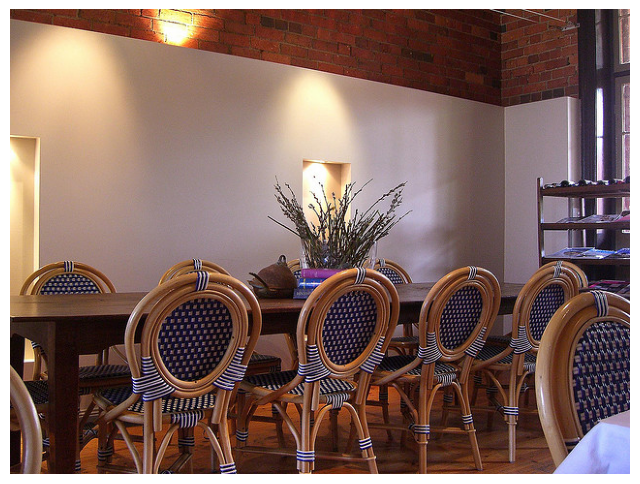

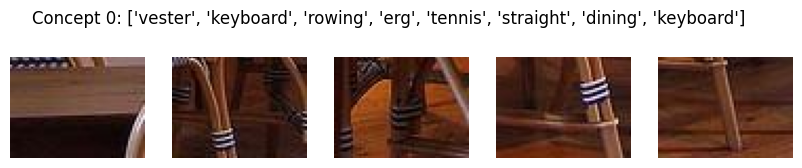

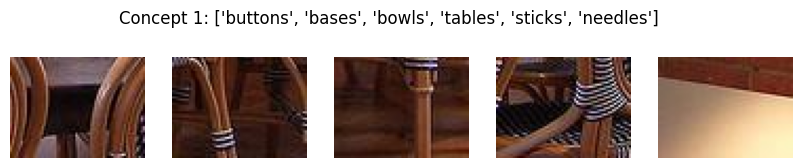

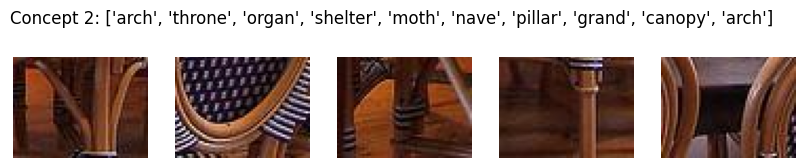

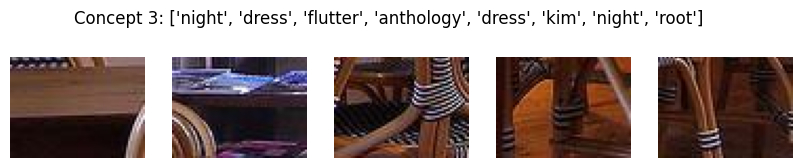

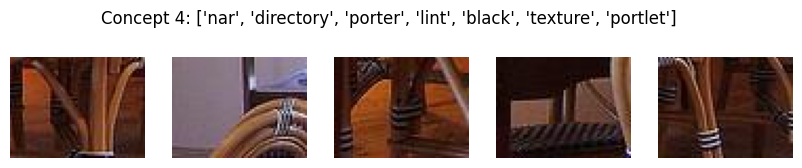

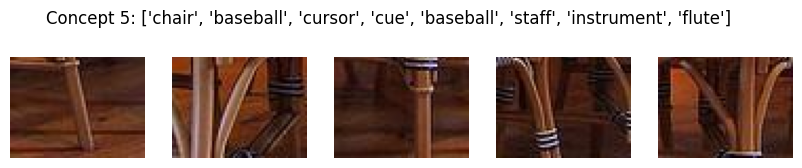

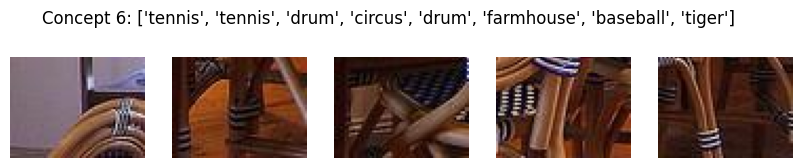

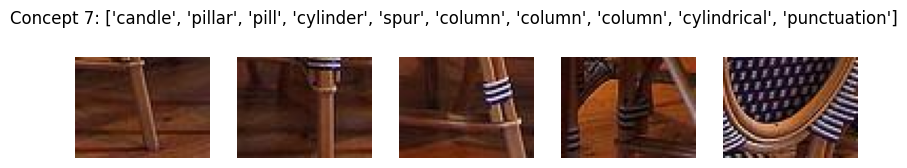

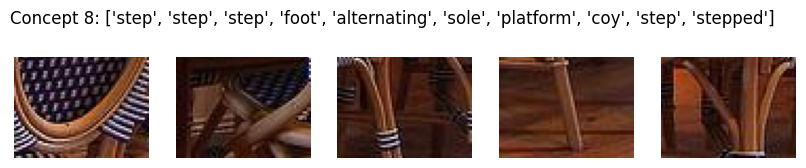

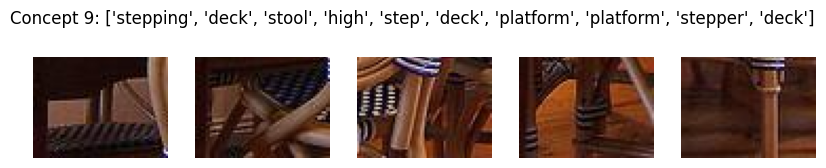

In [91]:
a_test_image = '/ds/images/coco_2014/train2014/COCO_train2014_000000057870.jpg'
local_explantin(a_test_image, test_data_remapped )

## Show patch in image

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def get_patch_info(patch_path):
    """
    Extract patch coordinates and size from the patch file path and image.

    Parameters:
        patch_path (str): Path to the patch image file.

    Returns:
        tuple: (patch_coords, patch_size), where patch_coords is a tuple (x, y),
               and patch_size is the size of the patch.
    """
    # Extract patch coordinates from the file name
    file_name = os.path.basename(patch_path)
    parts = file_name.split('_')
    x = int(parts[-2])  # Extract x-coordinate
    y = int(parts[-1].split('.')[0])  # Extract y-coordinate

    # Determine patch size from the image
    patch_img = Image.open(patch_path)
    patch_width, patch_height = patch_img.size

    if patch_width != patch_height:
        raise ValueError("Patch is not square. Please provide a square patch.")

    return (x, y), patch_width

def highlight_patch(main_image_path, patch_path):
    """
    Highlights a specific patch in the main image.

    Parameters:
        main_image_path (str): Path to the main image.
        patch_path (str): Path to the patch image file.
    """
    # Get patch info
    patch_coords, patch_size = get_patch_info(patch_path)

    # Load the main image
    main_img = Image.open(main_image_path)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the main image
    ax.imshow(main_img)

    # Calculate patch position (top-left corner of the patch)
    x, y = patch_coords

    # Draw a rectangle around the patch
    rect = patches.Rectangle(
        (x * patch_size, y * patch_size),  # Top-left corner
        patch_size,  # Width
        patch_size,  # Height
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )

    # Add the rectangle to the plot
    ax.add_patch(rect)

    # Display the result
    plt.axis('off')
    plt.show()

In [40]:
main_image_path = "/path/to/main_image.jpg"
patch_path = "/home/kadir/xl-vlms/playground/output_patches/synpic32933_patch_0_0.jpg"
highlight_patch(main_image_path, patch_path)

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/main_image.jpg'